# Predict survival on Titanic
https://www.kaggle.com/c/titanic/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
# Set the default visualisation to seaborn layout
sns.set()

## Preliminary data analysis

### Load the train and test data

In [2]:
train = pd.read_csv('./data/train.csv', 
            index_col='PassengerId', dtype = {'Pclass': 'category'}
           )
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Basic statistics

P value threshold is 0.05

In [3]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

There are 177 values missing in Age, 687 in Cabin and 2 in Embarked

In [4]:
train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


The difference between the min and max value in Fare is very different.

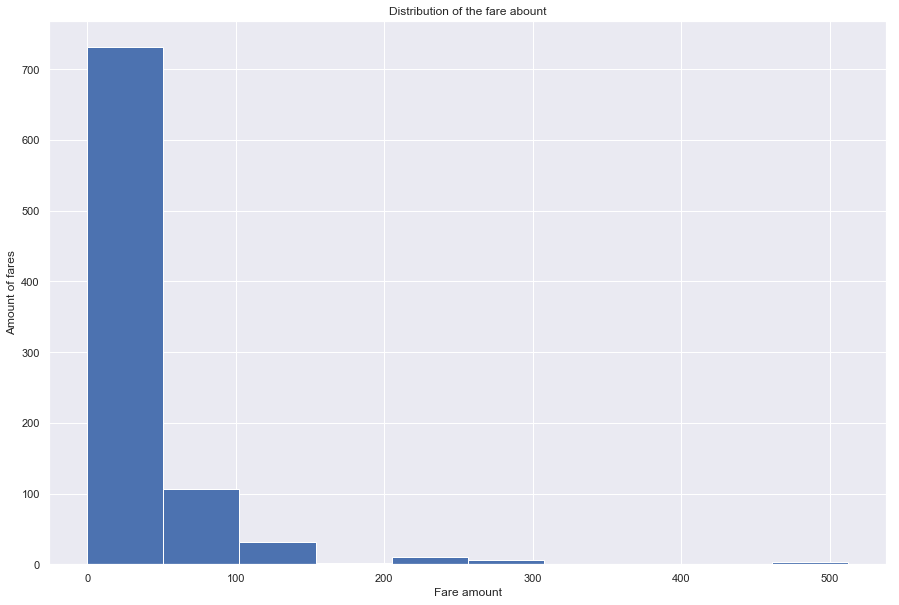

In [5]:
plt.title('Distribution of the fare abount')
plt.xlabel('Fare amount')
plt.ylabel('Amount of fares')
train['Fare'].hist(figsize=(15,10), );

The data Fare amount data is right skewed, there are a couple of outliers which paid way more than the rest. 

Get the fare which paid 3 times more than the standard deviation + mean ==> outliers

In [6]:
outliers = train[train['Fare'] > train['Fare'].std()*3 + train['Fare'].mean()]
'There are {} outliers in the Fare columns'.format(outliers.shape[0])

'There are 20 outliers in the Fare columns'

In [7]:
train.loc[outliers.index, 'Fare'] = None
train['Fare'] = train.groupby(['Pclass'])['Fare']\
    .transform(lambda x: x.fillna(x.mean()))

Replace the outliers with the average of the Pclass.

In [8]:
'{:0.2%} of passengers survived'.format(train['Survived'].mean())

'38.38% of passengers survived'

#### Classes

In [9]:
sur_per_class = train.groupby('Pclass')['Survived'].mean()
for key, i in sur_per_class.iteritems():
    print('{:0.2%} of the class {} survived'.format(i, key))

62.96% of the class 1 survived
47.28% of the class 2 survived
24.24% of the class 3 survived


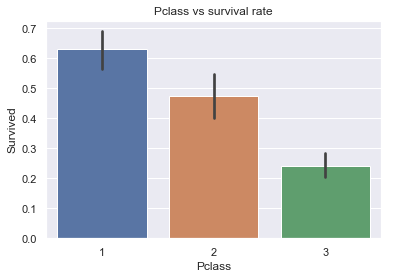

In [10]:
plt.title('Pclass vs survival rate')
sns.barplot(data=train, x='Pclass', y='Survived');

#### Test if there is a significant difference between the survival rate between the classes

In [11]:
o_vs_two = stats.ttest_ind(train.loc[train['Pclass'] == '1', 'Survived'], 
    train.loc[train['Pclass'] == '2', 'Survived'])
'The p-value ({}) of the survivel rate between class 1 and 2 is significant which \
means that people in class one had more chance of survival than people in class two (based on the prevous chart)'.format(o_vs_two[1])

'The p-value (0.0015954656668372637) of the survivel rate between class 1 and 2 is significant which means that people in class one had more chance of survival than people in class two (based on the prevous chart)'

In [12]:
o_vs_thr = stats.ttest_ind(train.loc[train['Pclass'] == '1', 'Survived'], 
    train.loc[train['Pclass'] == '3', 'Survived'])
'The p-value ({}) of the survivel rate between class 1 and 3 is significant which \
means that people in class one had more chance of survival than people in class three (based on the prevous chart)'.format(o_vs_thr[1])

'The p-value (1.4803959119909571e-24) of the survivel rate between class 1 and 3 is significant which means that people in class one had more chance of survival than people in class three (based on the prevous chart)'

In [13]:
two_vs_thr = stats.ttest_ind(train.loc[train['Pclass'] == '2', 'Survived'], 
    train.loc[train['Pclass'] == '3', 'Survived'])
'The p-value ({}) of the survivel rate between class 2 and 3 is significant which \
means that people in class two had more chance of survival than people in class three (based on the prevous chart)'.format(two_vs_thr[1])

'The p-value (4.824799495146526e-09) of the survivel rate between class 2 and 3 is significant which means that people in class two had more chance of survival than people in class three (based on the prevous chart)'

The chart above clearly shows that people in class 1 had a higher survival rate than poeple in class 2 and 3. People in class tho also had a higer survival rate than people in class 3

#### Sex

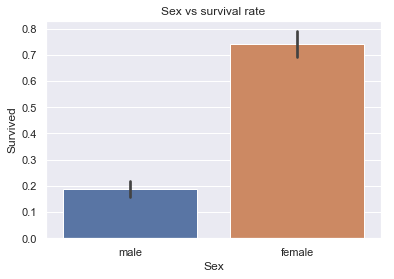

In [14]:
plt.title('Sex vs survival rate')
sns.barplot(data=train, x='Sex', y='Survived');

In [15]:
sex_t = stats.ttest_ind(train.loc[train['Sex']=='male', 'Survived'], 
                  train.loc[train['Sex']=='female', 'Survived'])
'The p-value ({}) of the survivel rate between male and female is significant which \
means female people had a higher chance of survival than men (based on the previous chart)'.format(sex_t[1])

'The p-value (1.4060661308802594e-69) of the survivel rate between male and female is significant which means female people had a higher chance of survival than men (based on the previous chart)'

#### Embarked

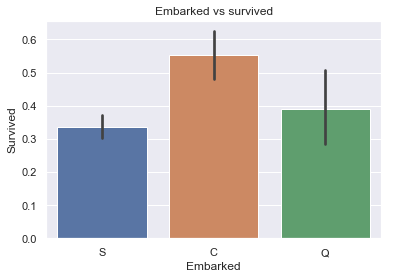

In [16]:
plt.title('Embarked vs survived')
sns.barplot(data=train, x='Embarked', y='Survived');

In [17]:
c_vs_s = stats.ttest_ind(train.loc[train['Embarked']=='S', 'Survived'], 
                  train.loc[train['Embarked']=='C', 'Survived'])
'The p-value ({}) of the survivel rate between embarking from C and S is significant which \
means people who embarked in C had a higher chance of survival than people who embarked in S (based on the previous chart)'.format(c_vs_s[1])

'The p-value (2.2014370315889943e-07) of the survivel rate between embarking from C and S is significant which means people who embarked in C had a higher chance of survival than people who embarked in S (based on the previous chart)'

In [18]:
c_vs_s = stats.ttest_ind(train.loc[train['Embarked']=='C', 'Survived'], 
                  train.loc[train['Embarked']=='Q', 'Survived'])
'The p-value ({}) of the survivel rate between embarking from Q and C is significant which \
means people who embarked in C had a higher chance of survival than people who embarked in Q (based on the previous chart)'.format(c_vs_s[1])

'The p-value (0.017100079516725354) of the survivel rate between embarking from Q and C is significant which means people who embarked in C had a higher chance of survival than people who embarked in Q (based on the previous chart)'

In [19]:
c_vs_s = stats.ttest_ind(train.loc[train['Embarked']=='S', 'Survived'], 
                  train.loc[train['Embarked']=='Q', 'Survived'])
'The p-value ({}) of the survivel rate between embarking from Q and S is not significant which \
means people who embarked in S didn"t have a higher chance of survival than people who embarked in Q (based on the previous chart)'.format(c_vs_s[1])

'The p-value (0.3581991404268985) of the survivel rate between embarking from Q and S is not significant which means people who embarked in S didn"t have a higher chance of survival than people who embarked in Q (based on the previous chart)'

Check is there might be a relation between the embarkation and the pclass

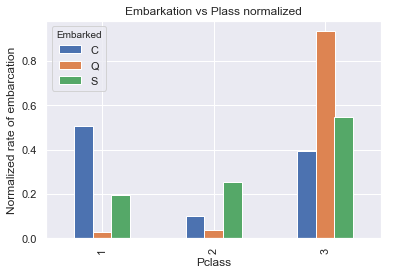

In [20]:
fig, ax = plt.subplots(1,1)
plt.title('Embarkation vs Plass normalized')
plt.ylabel('Normalized rate of embarcation')
train.groupby('Embarked')['Pclass'].value_counts(normalize=True).unstack().T.plot.bar(ax=ax);

- Embarkation from 'C' was mainly for 1 Pclass ==> this is also what we see in the survival rates above
- Embarkation from 'S' was mainly for 2 Pclass
- Embarkation from 'Q' was mainly for 3 Pclass

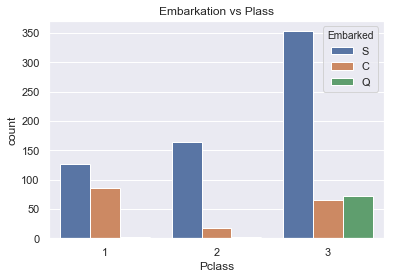

In [21]:
plt.title('Embarkation vs Plass')
sns.countplot(data=train, x='Pclass', hue='Embarked');

#### SibSp

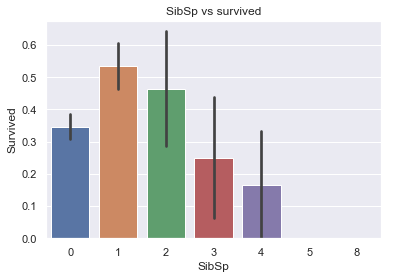

In [22]:
plt.title('SibSp vs survived')
sns.barplot(x='SibSp', y='Survived', data=train);

In [23]:
sib_t = stats.ttest_ind(train.loc[train['SibSp']>2, 'Survived'], 
                  train.loc[train['SibSp']<=2, 'Survived'])
'The p-value ({}) of the survivel rate between people with 2 or less and more than 2 siblings is significant which \
means people with less than or 2 siblings on board had a higher chance of survival than people with more than 2 \
siblings (based on the previous chart)'.format(sib_t[1])

'The p-value (0.0008896899432353292) of the survivel rate between people with 2 or less and more than 2 siblings is significant which means people with less than or 2 siblings on board had a higher chance of survival than people with more than 2 siblings (based on the previous chart)'

#### Parch

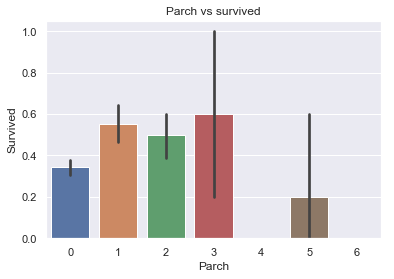

In [24]:
plt.title('Parch vs survived')
sns.barplot(x='Parch', y='Survived', data=train);

In [25]:
par_t = stats.ttest_ind(train.loc[train['Parch']>2, 'Survived'], 
                  train.loc[train['Parch']<=2, 'Survived'])
'The p-value ({}) of the survival rate between people with 2 or less and more than 2 parents or children is not significant which \
means people with less than or 2 parents or children on board didn"t have a higher chance of survival than people with more than 2 \
parents or children (based on the previous chart)'.format(par_t[1])


'The p-value (0.34721342555620416) of the survival rate between people with 2 or less and more than 2 parents or children is not significant which means people with less than or 2 parents or children on board didn"t have a higher chance of survival than people with more than 2 parents or children (based on the previous chart)'

#### Fare

Create fare bins

In [26]:
train['Fare_cat'] = pd.cut(train['Fare'], 10, precision=0, labels=False)

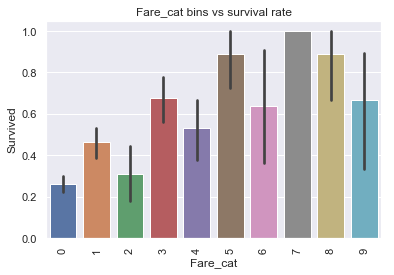

In [27]:
plt.title('Fare_cat bins vs survival rate')
plt.xticks(rotation='vertical')
sns.barplot(x='Fare_cat', y='Survived', data=train);

In [28]:
fare_t = stats.ttest_ind(train.loc[train['Fare']>50, 'Survived'], 
                  train.loc[train['Fare']<=50, 'Survived'])
'The p-value ({}) of the survival rate between people who paid less than or equal to 50 and more than 50 significant which \
means people who paid more to 50 had a higher chance of survival than people who paid less than or equal to 50 \
(based on the previous chart)'.format(fare_t[1])


'The p-value (3.0087656555098563e-18) of the survival rate between people who paid less than or equal to 50 and more than 50 significant which means people who paid more to 50 had a higher chance of survival than people who paid less than or equal to 50 (based on the previous chart)'

## Feature engeneering

In [29]:
titanic = train.copy()
#titanic['Pclass'] = titanic['Pclass'].astype('category')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [30]:
titanic['Pclass'].unique()

[3, 1, 2]
Categories (3, object): [3, 1, 2]

### Feature generation

Find the Titles in the Name columns based on a regular expression that ends with a dot (.)

In [31]:
titanic['Title'] = titanic['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

In [32]:
titanic['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Replace 'Mlle' and 'Ms' with 'Miss' and 'Mme' by 'Mrs', as these are French titles and replace special titles like Capt, Col, Dr, ... with Special

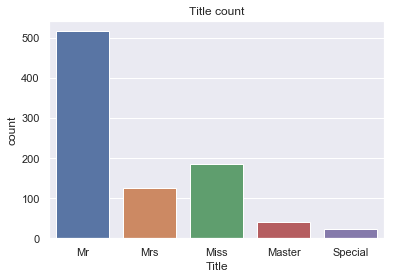

In [33]:
plt.title('Title count')
titanic['Title'] = titanic['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
titanic['Title'] = titanic['Title'].replace(['Don', 'Dona', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=titanic);

In [34]:
'Number of records with Cabin missing {}'.format(titanic['Cabin'].isnull().sum())

'Number of records with Cabin missing 687'

In [35]:
titanic['Has_cabin'] = ~titanic['Cabin'].isnull()

In [36]:
titanic['Fare_cat'] = pd.cut(titanic['Fare'], 10, precision=0, labels=False)

In [37]:
# plus 1 to include the passenger himself/herself
titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1 

In [38]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Has_cabin,Family_size
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,False,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,Mrs,True,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,False,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3,Mrs,True,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,False,1


### Calculate missing data

In [39]:
titanic.count()

Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
Fare_cat       891
Title          891
Has_cabin      891
Family_size    891
dtype: int64

#### Embarked

Get the values where the embarkation is missing.

In [40]:
titanic[titanic['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Has_cabin,Family_size
PassengerId,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,4,Miss,True,1
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,4,Mrs,True,1


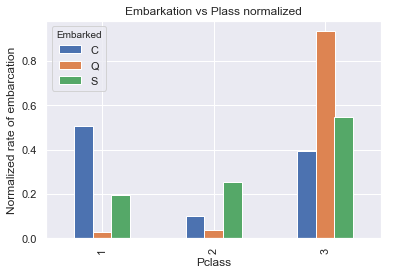

In [41]:
fig, ax = plt.subplots(1,1)
plt.title('Embarkation vs Plass normalized')
plt.ylabel('Normalized rate of embarcation')
train.groupby('Embarked')['Pclass'].value_counts(normalize=True).unstack().T.plot.bar(ax=ax);

Relativly seen both people have the highest chance to have embarked in 'C' so fill them with 'C'

In [42]:
titanic.loc[titanic['Embarked'].isnull(), 'Embarked'] = 'C'

#### Age

Calculate the missing ages based on the following group of columns 'Title', 'Pclass', 'Fare_cat'
Following columns ('Has_cabin', 'Sex')  are not included because this makes the records to unique ==> doesn't fill all the missing rows.

In [43]:
titanic.groupby(['Fare_cat'])['Age'].mean()

Fare_cat
0    28.579543
1    28.730807
2    25.000000
3    35.310345
4    36.777778
5    35.470588
6    33.200000
7    24.250000
8    40.285714
9    29.102222
Name: Age, dtype: float64

In [44]:
titanic[titanic['Age'].isnull()].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Has_cabin,Family_size
PassengerId,,,,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,Mr,False,1
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0,Mr,False,1
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,Mrs,False,1
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0,Mr,False,1
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,Miss,False,1


In [45]:
titanic['Age'] = titanic.groupby(['Has_cabin','Pclass', 'Title'])['Age']\
    .transform(lambda x: x.fillna(x.mean()))

In [46]:
titanic.count()

Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       891
Fare_cat       891
Title          891
Has_cabin      891
Family_size    891
dtype: int64

In [47]:
titanic[titanic['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Has_cabin,Family_size
PassengerId,,,,,,,,,,,,,,,


In [48]:
titanic['Age_cat'] = pd.cut(titanic['Age'], 10, labels=False)

In [49]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat,Title,Has_cabin,Family_size,Age_cat
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,False,2,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,Mrs,True,2,4
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,False,1,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3,Mrs,True,2,4
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,False,1,4


## Machine learning

Remove the colums that are not used.

In [50]:
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'Age', 'Fare'], axis=1)

Transform all variables into numeric ones. We do this because machine learning models take numeric input.

In [51]:
titanic_dum = pd.get_dummies(titanic)
titanic_dum.head()

,Survived,SibSp,Parch,Fare_cat,Has_cabin,Family_size,Age_cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,False,2,2,0,0,1,0,1,0,0,1,0,0,1,0,0
2,1,1,0,4,True,2,4,1,0,0,1,0,1,0,0,0,0,0,1,0
3,1,0,0,0,False,1,3,0,0,1,1,0,0,0,1,0,1,0,0,0
4,1,1,0,3,True,2,4,1,0,0,1,0,0,0,1,0,0,0,1,0
5,0,0,0,0,False,1,4,0,0,1,0,1,0,0,1,0,0,1,0,0


Train ==> get all the rows where the Survived columns is not empty.


Split the train in X (the features) and y the outcome to fit on.

In [52]:
from sklearn.model_selection import train_test_split
X = titanic_dum[titanic_dum.columns[titanic_dum.columns.values != 'Survived']].values
y = titanic_dum['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Apply a gridsearch algorithm to the decision tree classifier to test the best params.

### DecisionTreeClassifier

In [53]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid = {'max_depth' : dep}

# Instantiate a decision tree classifier: clf
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X_train, y_train)
pred = clf_cv.predict(X_test)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8271812080536913


In [54]:
'The decision tree classified {:0.0%} of the values correct'.format(accuracy_score(y_test, pred))

'The decision tree classified 81% of the values correct'

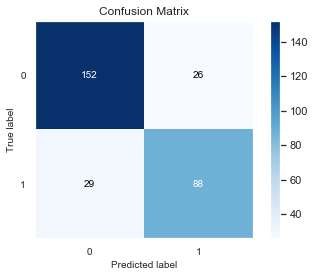

In [55]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=pred);

In [56]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid ={"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_features = "auto", 
                                                class_weight = "balanced",
                                                max_depth = 4))
# Instantiate the GridSearchCV object: clf_cv
bdt_cv = GridSearchCV(bdt, param_grid=param_grid)

bdt_cv.fit(X_train, y_train)
pred = bdt_cv.predict(X_test)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(bdt_cv.best_params_))
print("Best score is {}".format(bdt_cv.best_score_))

Tuned Decision Tree Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 2}
Best score is 0.8003355704697986


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [57]:
'The adaboost algorithm combined with decision trees classified {:0.0%} of the values correct'.format(accuracy_score(y_test, pred))

'The adaboost algorithm combined with decision trees classified 79% of the values correct'

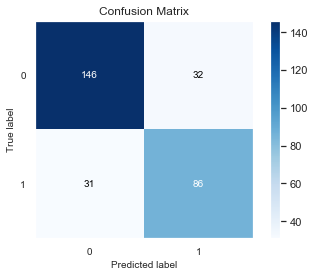

In [58]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=pred);

### LogisticRegression

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
max_iter = np.arange(1,50)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':max_iter, 'penalty': ['l1', 'l2']}

logmodel = LogisticRegression()

logmodel_cv = GridSearchCV(logmodel, param_grid=param_grid)
logmodel_cv.fit(X_train, y_train)
pred = logmodel_cv.predict(X_test)

# Print the tuned parameter and score
print("Logistic regression: {}".format(logmodel_cv.best_params_))
print("Best score is {}".format(logmodel_cv.best_score_))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be change

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceW

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWar

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceW

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceW

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWar

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

Logistic regression: {'C': 1, 'max_iter': 2, 'penalty': 'l1'}
Best score is 0.8288590604026845


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [61]:
'The logistic regression classified {:0.0%} of the values correct'.format(accuracy_score(y_test, pred))

'The logistic regression classified 83% of the values correct'

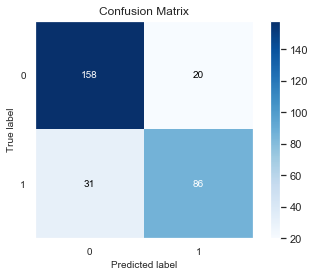

In [62]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=pred);

In [63]:
# Setup the hyperparameter grid
max_iter = np.arange(1,50)
param_grid ={"base_estimator__C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "base_estimator__max_iter" : max_iter,
              "n_estimators": [1, 2],
             'base_estimator__penalty': ['l1', 'l2']
             }


# Create and fit an AdaBoosted decision tree
blr = AdaBoostClassifier(LogisticRegression())
# Instantiate the GridSearchCV object: clf_cv
blr_cv = GridSearchCV(blr, param_grid=param_grid, n_jobs=-1)

blr_cv.fit(X_train, y_train)
pred = blr_cv.predict(X_test)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(blr_cv.best_params_))
print("Best score is {}".format(blr_cv.best_score_))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Tuned Decision Tree Parameters: {'base_estimator__C': 100, 'base_estimator__max_iter': 3, 'base_estimator__penalty': 'l2', 'n_estimators': 2}
Best score is 0.8305369127516778


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
'The logistic regression with adaboost classified {:0.0%} of the values correct'.format(accuracy_score(y_test, pred))

'The logistic regression with adaboost classified 83% of the values correct'

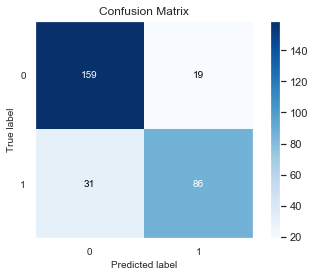

In [65]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=pred);

### RandomForestClassifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
# Create and fit an AdaBoosted decision tree

param_grid ={"criterion" : ["gini", "entropy"],
              "n_estimators": [1, 2, 5, 10, 20]
             }

rfc = RandomForestClassifier()
# Instantiate the GridSearchCV object: clf_cv
rfc_cv = GridSearchCV(rfc, param_grid=param_grid, n_jobs=-1)

rfc_cv.fit(X_train, y_train)
pred = rfc_cv.predict(X_test)

# Print the tuned parameter and score
#print("Tuned Decision Tree Parameters: {}".format(rfc.best_params_))
#print("Best score is {}".format(rfc.best_score_))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [68]:
'The logistic regression with adaboost classified {:0.0%} of the values correct'.format(accuracy_score(y_test, pred))

'The logistic regression with adaboost classified 80% of the values correct'

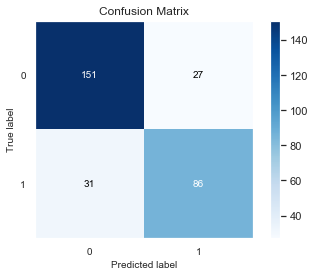

In [69]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=pred);

# Conclusion

Logistic regression machine learning model has the best score.